In [1]:
import landscapes
import convert_generator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

In [2]:
INTERPOLATION = 1
NOISE = 1

In [3]:
DEEP_CUTOFF = 0.05
SHALLOW_CUTOFF = 0.005

In [4]:
plt.style.use('default')

def save_fig(name):
    prefix = "figures/interpolated_x{}/".format(INTERPOLATION) + ("" if NOISE is None else "noise_v{}/".format(NOISE))
    plt.savefig(prefix + name + '.pdf', bbox_inches='tight', transparent=True)
    plt.savefig(prefix + name + '.png', bbox_inches='tight', transparent=True, dpi=900)

MARKER_SIZE = 10
LINE_WIDTH = 0.1

DEPTH_PALETTE={'Shallow': '#e9a3c9', 'Neither': '#c2c2c2', 'Deep': '#a1d76a'}

CLUSTER_PALETTE={'Other': '#D7D9D7',
                 '3KZK': '#F06AA7',
                 '1J85': '#340068',
                 '1FUG': '#B287A3',
                 '6QQW': '#FFC100',
                 '1UAK': '#F67A28',
                 '2V3J': '#5CB42D',
                 '3ZNC': '#E01300',
                 '6RQQ': '#00AFF5',
                 '4QEF': '#6B8EC7'}

DIAGRAM_COLOUR = '#6baed6'

plt.rcParams['figure.figsize'] = (2.5,2.5)


plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['font.size'] = 10
plt.rcParams['legend.title_fontsize'] = 9

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [5]:
if NOISE is None:
    LANDSCAPE_FILE = "./data/validation/landscapes/interpolated_x{}/{}_1.lan".format(INTERPOLATION, '{}')
else:
    LANDSCAPE_FILE = "./data/validation/landscapes/interpolated_x{}/noise_v{}/{}_1.lan".format(INTERPOLATION, NOISE, '{}')

if NOISE is None:
    DIAGRAM_FILE = "./data/validation/diagrams/interpolated_x{}/{}_1.txt".format(INTERPOLATION, '{}')
else:
    DIAGRAM_FILE = "./data/validation/diagrams/interpolated_x{}/noise_v{}/{}_1.txt".format(INTERPOLATION, NOISE, '{}')



def load_landscape(chain):
    return landscapes.load(LANDSCAPE_FILE.format(chain))

def load_diagram(chain):
    return np.loadtxt(DIAGRAM_FILE.format(chain))

In [6]:
def scatterplot_underneath(df, category, value, **kwargs):
    ax = sns.scatterplot(data=df[df[category] == value], **kwargs)
    sns.scatterplot(ax=ax, data=df[df[category] != value], **kwargs)
    return ax

In [7]:
def plot_diagram(barcode, lower=0, upper=10):
    births, deaths = np.array([(b,d) for (b,d) in barcode if d - b > 0.2]).T
    
    ax = sns.lineplot(x=[0,upper+1], y=[0,upper+1], style=True, dashes=[(2,2)], color='black')
    
    sns.scatterplot(ax=ax, x=births, y=deaths,color=DIAGRAM_COLOUR,
                    edgecolor="DarkSlateGray", s=MARKER_SIZE, linewidth=LINE_WIDTH)
    
    ax.set_xlim([lower,upper])
    ax.set_ylim([lower,upper])
    ax.get_legend().remove()
    
    ax.set_ylabel("Death")
    ax.set_xlabel("Birth")

    return ax

def plot_landscape(landscape, xlim=None, ylim=None, colors=None, linewidths=None, labels=None):
    fig, ax = landscape.plot(linewidths=linewidths, colors=colors, labels=labels)
    
    ax.set_xlabel("$t$")
    ax.set_ylabel("$\lambda_k(t)$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return fig, ax

In [8]:
# Every trefoil protein considered in Sections 2 and 3
trefoil_df = pd.read_csv('trefoil_list.csv')

# We just relabel representatives here, so e.g. 4qef_A becomes 4QEF in the representative column
# This is for aesthetic reasons, and also because the underscore would cause problems with TeX rendering
trefoil_df.Representative = list(map(lambda x: x if x == 'Other' else x[:4].upper(), trefoil_df.Representative))

# Add depth categories according to the cutoffs
def depth_category(row):
    depth = row['Depth']
    if depth > DEEP_CUTOFF:
        return 'Deep'
    if depth < SHALLOW_CUTOFF:
        return 'Shallow'
    return 'Neither'

trefoil_df['Depth category'] = trefoil_df.apply(depth_category, axis=1)

trefoil_df

,Chain,Depth,Length,N-tail,C-tail,Representative,Depth category
0,6i0j_A,0.001136,257,25,3,4QEF,Shallow
1,6i0w_A,0.001382,258,23,4,4QEF,Shallow
2,6hr3_A,0.001037,258,23,3,4QEF,Shallow
3,6nj4_A,0.004579,266,27,12,4QEF,Shallow
4,6nj5_A,0.003816,266,27,10,4QEF,Shallow
...,...,...,...,...,...,...,...
508,2o3a_A,0.132525,167,77,48,Other,Deep
509,2qwv_A,0.089893,202,131,28,Other,Deep
510,3o7b_A,0.083333,216,144,27,Other,Deep
511,1o6d_A,0.096117,147,67,31,Other,Deep


# Figure 1

## 1C

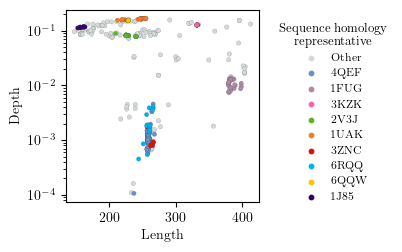

In [9]:
args = dict(x="Length", y="Depth",
            hue="Representative", palette=CLUSTER_PALETTE,
            edgecolor="DarkSlateGray", s=MARKER_SIZE, linewidth=LINE_WIDTH)

ax = scatterplot_underneath(trefoil_df, "Representative", "Other", **args)

ax.set_yscale("log")

legend = ax.legend(bbox_to_anchor=(1.05, 0.98), title='Sequence homology \n representative',
                   loc='upper left', prop={'size': 8}, frameon=False)

plt.setp(legend.get_title(), multialignment='center')

for i in range(10):
    legend.legendHandles[i]._sizes = [MARKER_SIZE]
    
save_fig("lengthvdepth-cluster")

## 1D

In [10]:
REP_FILE = "./data/generators/reps/interpolated_x{}/{}_representative_{}.txt".format(INTERPOLATION, '{}', '{}')

def get_representative(chain, i):
    segs = np.loadtxt(REP_FILE.format(chain, i), dtype='int').T
    return convert_generator.convert(segs)

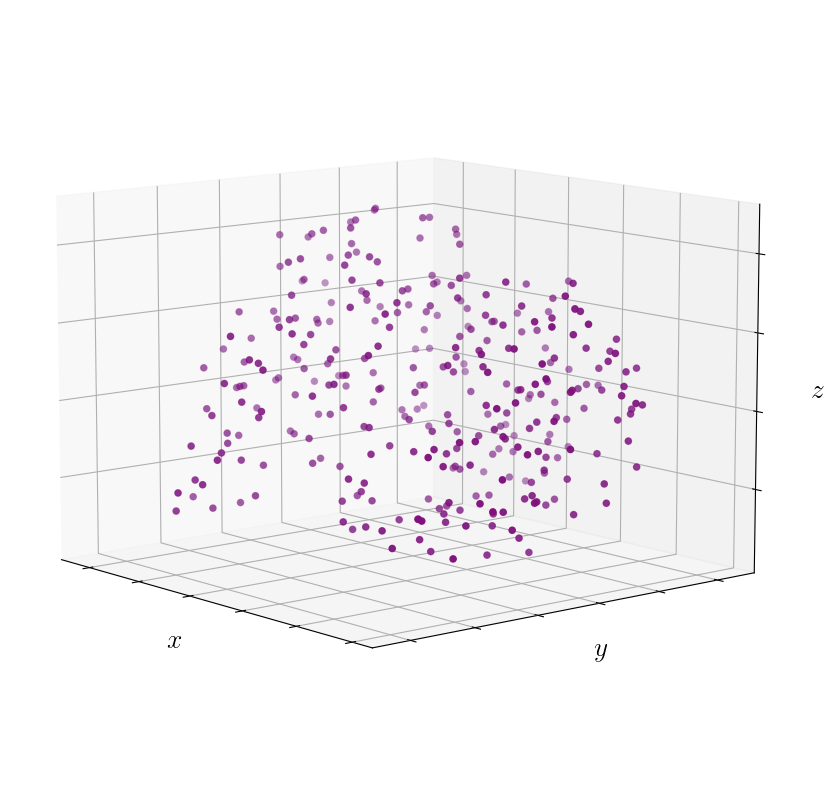

In [11]:
CARBON_COLOUR = '#810f7c'
INTERP_COLOUR = '#8c96c6'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

interp_pts = np.loadtxt("./data/chains/interpolated_x{}/noise_v1/3kzk_A.xyz".format(INTERPOLATION))
xs, ys, zs = interp_pts.T
ax.scatter(xs, ys, zs, s = 5, color=INTERP_COLOUR)

base_pts = np.loadtxt("./data/chains/interpolated_x1/noise_v1/3kzk_A.xyz")
xs, ys, zs = base_pts.T
ax.scatter(xs, ys, zs, color=CARBON_COLOUR)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$y$", fontsize=20)
ax.set_zlabel("$z$", fontsize=20)

ax.view_init(10, 320)

save_fig("3kzk_chain")

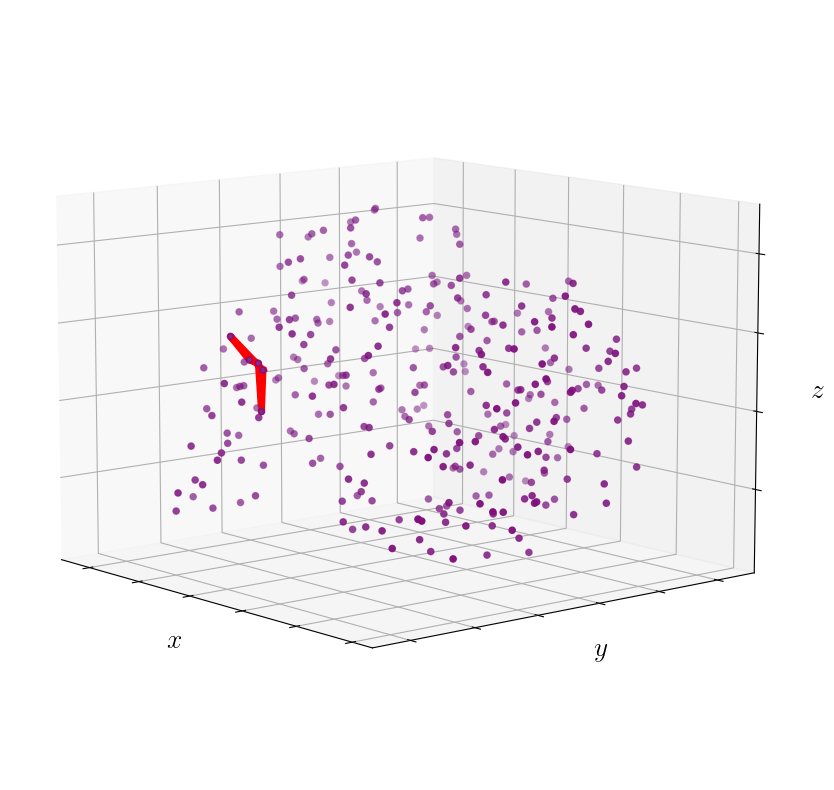

In [12]:
rep, bridges = get_representative('3kzk_A', 188)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = interp_pts.T
ax.scatter(xs, ys, zs, s = 5, color=INTERP_COLOUR)

xs, ys, zs = base_pts.T
ax.scatter(xs, ys, zs, color=CARBON_COLOUR)

gen = np.array(list(map(lambda x: interp_pts[x-1], rep)))
xs,ys,zs = gen.T
ax.plot(xs,ys,zs,color='red', linewidth=5, alpha=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$y$", fontsize=20)
ax.set_zlabel("$z$", fontsize=20)

ax.view_init(10, 320)

save_fig("3kzk_chain_generator")

## 1E

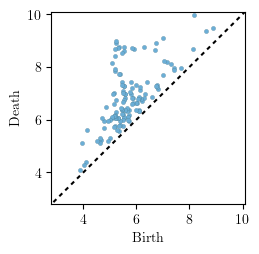

In [13]:
barcode = load_diagram("3kzk_A")

ax = plot_diagram(barcode, lower=2.8, upper=10.1)

save_fig("diagram-3kzk")

## 1E

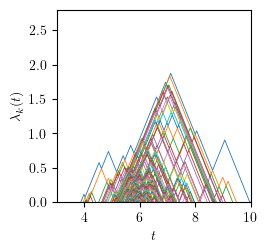

In [14]:
xlim = [3,10]
ylim = [0,2.8]

landscape_3kzk = load_landscape("3kzk_A")

fig, ax = plot_landscape(landscape_3kzk, xlim, ylim, linewidths=[0.6]*landscape_3kzk.max_k())

save_fig("landscape-3kzk")

# Figure 2

## 2A and 2B

In [15]:
def add_embedding_to_df(dataframe, embedding, name):
    x, y = embedding.T
    dataframe["{} x".format(name)] = x
    dataframe["{} y".format(name)] = y
    
add_embedding_to_df(trefoil_df, 
                    np.loadtxt('./data/validation/wass_iso_x{}_v{}.txt'.format(INTERPOLATION, NOISE)),
                    "wass isomap")
add_embedding_to_df(trefoil_df,
                    np.loadtxt('./data/validation/landscape_iso_x{}_v{}.txt'.format(INTERPOLATION, NOISE)),
                    "landscape isomap")

In [16]:
def generate_isomap_figs(name, show_legends=True, title=None):
    
    # Used to access coordinates from dataframe
    x = "{} isomap x".format(name)
    y = "{} isomap y".format(name)
    
    # Common arguments for all plots
    args = dict(x=x, y=y, edgecolor="DarkSlateGray", s=MARKER_SIZE, linewidth=LINE_WIDTH)
    
    # SEQUENCE HOMOLOGY CLUSTERS
    ax = scatterplot_underneath(trefoil_df, "Representative", "Other",
                                hue="Representative", palette=CLUSTER_PALETTE, **args)

    # No axis used for isomap plots
    ax.axis('off')

    if show_legends:
        legend = ax.legend(bbox_to_anchor=(0.9, 1.03),
                           title='Sequence homology \n representative',
                           loc='upper left', prop={'size': 8}, frameon=False)
        plt.setp(legend.get_title(), multialignment='center') # Fix multiline alignment
        # Change marker size within legend
        for i in range(10):
            legend.legendHandles[i]._sizes = [MARKER_SIZE]
    else:
        ax.get_legend().remove()

    if title is not None:
        ax.set_title(title)
        
    save_fig("isomap-{}-cluster".format(name))
    plt.show()
    
    # DEPTH CLUSTERS
    ax = scatterplot_underneath(trefoil_df, "Depth category", "Neither",
                                hue='Depth category', palette=DEPTH_PALETTE, **args)
    
    ax.axis('off')

    if show_legends:
        legend = ax.legend(bbox_to_anchor=(1.51, 0.75), title='Depth category',
                           prop={'size': 8}, frameon=False)
        for i in range(3):
            legend.legendHandles[i]._sizes = [MARKER_SIZE]
    else:
        ax.get_legend().remove()
    
    # Save and display
    save_fig('isomap-{}-depth'.format(name))
    plt.show()

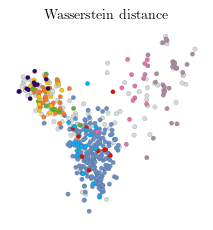

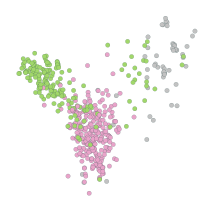

In [17]:
generate_isomap_figs("wass", show_legends=False, title="Wasserstein distance")

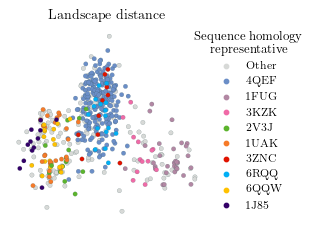

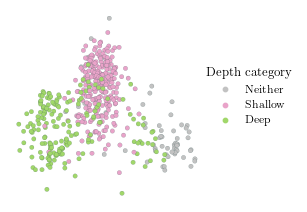

In [18]:
generate_isomap_figs("landscape", title="Landscape distance")

## 2C

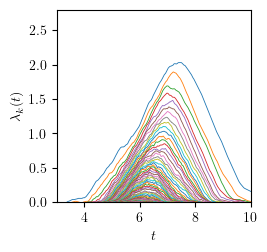

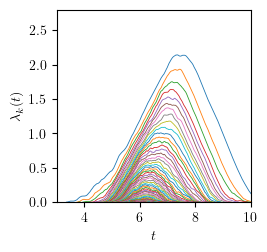

In [19]:
cluster_3znc = trefoil_df[trefoil_df.Representative == '3ZNC'].Chain
cluster_6rqq = trefoil_df[trefoil_df.Representative == '6RQQ'].Chain

avg_3znc = landscapes.average([load_landscape(chain) for chain in cluster_3znc])
avg_6rqq = landscapes.average([load_landscape(chain) for chain in cluster_6rqq])

xlim = [3,10]
ylim = [0,2.8]

fig, ax = plot_landscape(avg_3znc, xlim, ylim, linewidths=[0.6]*avg_3znc.max_k())
save_fig("average-3znc")

fig, ax = plot_landscape(avg_6rqq, xlim, ylim, linewidths=[0.6]*avg_6rqq.max_k())
save_fig("average-6rqq")

# Figure 3

In [20]:
GEN_LANDSCAPE_FILE = "./data/generators/landscapes/interpolated_x{}/noise_v{}/{}.lan".format(INTERPOLATION, NOISE, '{}')

def load_eirene_landscape(chain):
    return landscapes.load(GEN_LANDSCAPE_FILE.format(chain))

otcase_df = pd.read_csv("aotcase-otcase.csv")

knotted_landscapes = [load_eirene_landscape(chain) for chain in otcase_df[otcase_df.Type == 'knotted'].Chain]
unknotted_landscapes = [load_eirene_landscape(chain) for chain in otcase_df[otcase_df.Type == 'unknotted'].Chain]

## 3B

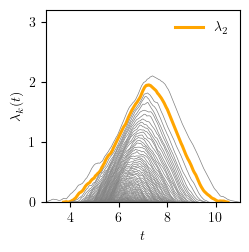

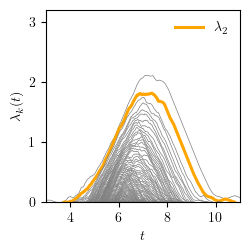

In [21]:
knotted_avg = landscapes.average(knotted_landscapes)
unknotted_avg = landscapes.average(unknotted_landscapes)

def ls_args(landscape):
    return dict(xlim=[3,11], ylim=[0,3.2],
                colors=['gray', 'orange'] + ['gray']*landscape.max_k(),
                linewidths=[0.5, 2.2]+[0.5]*landscape.max_k(),
                labels=['_nolegend_', '$\lambda_2$'] + ['_nolegend_']*landscape.max_k())

fig,ax = plot_landscape(knotted_avg, **ls_args(knotted_avg))
plt.legend(prop={'size': 10}, frameon=False)
save_fig("knotted-avg")
plt.show()


fig,ax = plot_landscape(unknotted_avg, **ls_args(unknotted_avg))
plt.legend(prop={'size': 10}, frameon=False)

save_fig("unknotted-avg")
plt.show()

## 3D

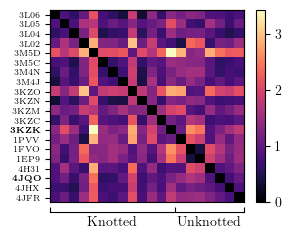

In [22]:
dm = np.loadtxt('./data/generators/truncated_dm_x{}_v{}.txt'.format(INTERPOLATION, NOISE))

fig, ax = plt.subplots(figsize=(3.12,2.5))

pos = ax.imshow(dm, cmap='magma')

fig.colorbar(pos)


#ax.set_xticks([12,17])
#ax.set_xticklabels(['3KZK', '4JQO'])
ax.set_xticks([])

ax.set_yticks(list(range(20)))

ax.set_yticklabels(['3L06', '3L05', '3L04', '3L02','3M5D','3M5C','3M4N',
                    '3M4J','3KZO', '3KZN', '3KZM', '3KZC', '\\textbf{3KZK}', '1PVV',
                    '1FVO', '1EP9', '4H31', '\\textbf{4JQO}', '4JHX', '4JFR'], fontsize=6)
ax2 = ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.646, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.32, 0.82]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['Knotted', 'Unknotted']))


save_fig('otcase-heatmap')